문제 1: 채널별 고객 획득 비용(CAC) 및 생애 가치(LTV) 분석
목표: 마케팅 채널의 진정한 ROI를 평가하기 위해 CAC와 LTV를 계산하고 최적 투자 전략을 제안하세요.
1. 데이터 로드 및 전처리
2. 채널별 CAC 계산
    - 2024년 데이터만 사용 - (2024년 마케팅데이터만 사용 -> `24년 채녈별 마케팅비용/24년 신규 획득 고객 수`)
    - 각 채널별 총 마케팅 비용 집계
    - 각 채널별 신규 고객 수 집계 (2024년 첫 거래 기준)
    - CAC = 총 마케팅 비용 / 신규 고객 수
    - organic과 referral 채널은 CAC = 0으로 처리
3. 고객별 LTV 계산 - 전체 구매 이력 기반
4. 채널별 LTV 및 ROI 분석 - (`24년 신규 고객들의 평균 LTV / 24년 CAC`)    
    - 채널별 평균 LTV 계산
    - ROI = LTV / CAC 계산 (organic, referral은 무한대 처리)
    - payback period = CAC / (월평균 구매금액) 계산
5. 시각화 및 전략 제안 (15분)
    - CAC vs LTV 산점도 차트
    - 채널별 ROI 막대 차트
    - 마케팅 예산 재배분 제안 (현재 vs 최적 배분)

문제 2: 고객 코호트 분석 및 유지율 개선 전략
목표: "월별 가입 코호트"의 유지율과 매출 기여도를 분석하여 고객 유지 전략을 수립하세요.
1. 코호트 그룹 생성
2. 월별 유지율 계산
    - 각 거래의 코호트 대비 경과 개월 수 계산
    - 코호트별 Month 0, 1, 2, ... 12에서의 활성 고객 수
    - 유지율 테이블 생성 (코호트 × 경과월)
    - 평균 유지율 곡선 계산
3. 코호트별 매출 기여도 분석
    - 각 코호트의 월별 누적 매출 계산
    - 코호트별 고객 1인당 누적 매출 (ARPU) 계산
    - 6개월 후, 12개월 후 예상 LTV 추정
4. 유지율 히트맵 시각화
5. 개선 전략 수립
    - 유지율이 급격히 감소하는 시점 식별
    - 고성과 코호트 vs 저성과 코호트 특성 비교
    - 유지율 개선을 위한 액션 아이템 3가지 제안

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
warnings.filterwarnings('ignore', category=UserWarning)

# 데이터 로드
transactions = pd.read_csv('customer_transactions.csv')
marketing = pd.read_csv('marketing_performance.csv')

# 날짜 변환
transactions['registration_date'] = pd.to_datetime(transactions['registration_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['month'] = pd.to_datetime(marketing['month'])

print("📊 데이터 기본 정보")
print("=" * 40)
print(f"거래 데이터: {len(transactions):,}건")
print(f"마케팅 데이터: {len(marketing):,}건")
print(f"분석 기간: {transactions['transaction_date'].min().date()} ~ {transactions['transaction_date'].max().date()}")

# 데이터 품질 체크
print(f"\n결측치 확인:")
print(f"거래 데이터: {transactions.isnull().sum().sum()}개")
print(f"마케팅 데이터: {marketing.isnull().sum().sum()}개")

📊 데이터 기본 정보
거래 데이터: 3,399건
마케팅 데이터: 120건
분석 기간: 2023-01-07 ~ 2024-12-31

결측치 확인:
거래 데이터: 0개
마케팅 데이터: 0개


In [2]:
print("\n🎯 2단계: 채널별 CAC 계산")
print("=" * 40)

# 2024년 마케팅 비용 집계
marketing_2024 = marketing[marketing['month'].dt.year == 2024]
channel_marketing_spend = marketing_2024.groupby('channel')['marketing_spend'].sum()

print("2024년 채널별 마케팅 비용:")
print(channel_marketing_spend.round(0))

# 2024년 신규 고객 식별 (첫 거래가 2024년인 고객)
customers_first_purchase = transactions.groupby('customer_id').agg({
    'transaction_date': 'min',
    'acquisition_channel': 'first'
}).reset_index()

# 2024년에 첫 거래한 고객들
new_customers_2024 = customers_first_purchase[
    customers_first_purchase['transaction_date'].dt.year == 2024
]

# 채널별 2024년 신규 고객 수
channel_new_customers = new_customers_2024.groupby('acquisition_channel').size()

print(f"\n2024년 채널별 신규 고객 수:")
print(channel_new_customers)

# CAC 계산
channel_cac = {}
for channel in channel_marketing_spend.index:
    if channel in channel_new_customers.index:
        if channel in ['organic', 'referral']:
            channel_cac[channel] = 0  # 무료 채널
        else:
            channel_cac[channel] = channel_marketing_spend[channel] / channel_new_customers[channel]
    else:
        channel_cac[channel] = 0

channel_cac = pd.Series(channel_cac)

print(f"\n💰 채널별 CAC (고객 획득 비용):")
print("=" * 30)
for channel, cac in channel_cac.items():
    if cac == 0:
        print(f"{channel:15}: $0 (무료 채널)")
    else:
        print(f"{channel:15}: ${cac:.2f}")


🎯 2단계: 채널별 CAC 계산
2024년 채널별 마케팅 비용:
channel
email           17763.0
organic             0.0
paid_search     97849.0
referral        11867.0
social_media    59629.0
Name: marketing_spend, dtype: float64

2024년 채널별 신규 고객 수:
acquisition_channel
email            64
organic         143
paid_search     128
referral         41
social_media     93
dtype: int64

💰 채널별 CAC (고객 획득 비용):
email          : $277.55
organic        : $0 (무료 채널)
paid_search    : $764.45
referral       : $0 (무료 채널)
social_media   : $641.17


In [3]:
print("\n📈 3단계: 고객별 LTV 계산")
print("=" * 40)

# 각 고객의 총 구매금액, 구매횟수, 구매기간 계산
customer_metrics = transactions.groupby('customer_id').agg({
    'order_value': ['sum', 'count', 'mean'],
    'transaction_date': ['min', 'max'],
    'acquisition_channel': 'first'
}).reset_index()

# 컬럼명 정리
customer_metrics.columns = ['customer_id', 'total_spent', 'order_count', 'avg_order_value', 
                           'first_purchase', 'last_purchase', 'acquisition_channel']

# 활동기간 계산 (일수)
customer_metrics['active_days'] = (
    customer_metrics['last_purchase'] - customer_metrics['first_purchase']
).dt.days + 1

# LTV 계산 (여러 방법)
# 방법 1: 단순 LTV = 총 구매금액 * (365 / 활동기간) * 예상수명(2년)
customer_metrics['annual_value'] = (
    customer_metrics['total_spent'] / customer_metrics['active_days'] * 365
)
customer_metrics['estimated_ltv'] = customer_metrics['annual_value'] * 2

# 방법 2: 보수적 LTV = 현재까지의 총 구매금액 * 1.5 (미래 구매 고려)
customer_metrics['conservative_ltv'] = customer_metrics['total_spent'] * 1.5

# 이상치 처리 (LTV가 너무 높거나 낮은 경우)
customer_metrics['estimated_ltv'] = customer_metrics['estimated_ltv'].clip(upper=5000)

print("LTV 계산 결과 (전체 고객 기준):")
print(customer_metrics[['estimated_ltv', 'conservative_ltv']].describe().round(2))

# 2024년 신규 고객들의 LTV만 추출
new_customer_ids_2024 = new_customers_2024['customer_id'].tolist()
new_customers_ltv = customer_metrics[customer_metrics['customer_id'].isin(new_customer_ids_2024)]

print(f"\n2024년 신규 고객 LTV 분석 ({len(new_customers_ltv)}명):")
print(new_customers_ltv[['estimated_ltv', 'active_days', 'order_count']].describe().round(2))


📈 3단계: 고객별 LTV 계산
LTV 계산 결과 (전체 고객 기준):
       estimated_ltv  conservative_ltv
count         978.00            978.00
mean         1866.46            432.25
std          1636.05            400.19
min           124.32             27.20
25%           723.53            161.10
50%          1156.22            294.54
75%          2244.31            520.88
max          5000.00           2181.84

2024년 신규 고객 LTV 분석 (469명):
       estimated_ltv  active_days  order_count
count         469.00       469.00       469.00
mean         2494.33       111.90         2.58
std          1853.61       101.32         1.55
min           124.32         1.00         1.00
25%           912.87         1.00         1.00
50%          1660.92       101.00         2.00
75%          5000.00       194.00         3.00
max          5000.00       341.00         8.00


In [4]:
print("\n🔍 4단계: 채널별 LTV 및 ROI 분석")
print("=" * 40)

# 채널별 평균 LTV 계산 (2024년 신규 고객 기준)
channel_avg_ltv = new_customers_ltv.groupby('acquisition_channel')['estimated_ltv'].agg([
    'mean', 'median', 'count'
]).round(2)

channel_avg_ltv.columns = ['평균_LTV', '중앙값_LTV', '고객수']

print("2024년 신규 고객의 채널별 LTV:")
print(channel_avg_ltv)

# ROI 계산 (LTV / CAC)
channel_roi = {}
for channel in channel_avg_ltv.index:
    ltv = channel_avg_ltv.loc[channel, '평균_LTV']
    cac = channel_cac.get(channel, 0)
    
    if cac == 0:
        roi = float('inf') if ltv > 0 else 0
    else:
        roi = ltv / cac
    
    channel_roi[channel] = roi

channel_roi = pd.Series(channel_roi)

# Payback Period 계산 (CAC / 월평균 구매금액)
monthly_revenue = new_customers_ltv.groupby('acquisition_channel').apply(
    lambda x: x['total_spent'].sum() / (x['active_days'].mean() / 30)
).fillna(0)

payback_period = {}
for channel in channel_cac.index:
    cac = channel_cac[channel]
    monthly_rev = monthly_revenue.get(channel, 0)
    
    if monthly_rev > 0:
        payback_period[channel] = cac / monthly_rev
    else:
        payback_period[channel] = float('inf')

payback_period = pd.Series(payback_period)

# 결과 종합 테이블
results_df = pd.DataFrame({
    '마케팅비용_2024': channel_marketing_spend.reindex(channel_cac.index, fill_value=0),
    '신규고객수': channel_new_customers.reindex(channel_cac.index, fill_value=0),
    'CAC': channel_cac,
    '평균_LTV': channel_avg_ltv['평균_LTV'].reindex(channel_cac.index, fill_value=0),
    'ROI': channel_roi,
    'Payback_개월': payback_period
}).round(2)

print(f"\n📊 채널별 성과 종합표:")
print("=" * 60)
print(results_df)

# 인사이트 도출
print(f"\n💡 주요 인사이트:")
print("=" * 20)

best_roi_channel = channel_roi[channel_roi < float('inf')].idxmax()
worst_roi_channel = channel_roi[channel_roi < float('inf')].idxmin()

print(f"🏆 최고 ROI 채널: {best_roi_channel} (ROI: {channel_roi[best_roi_channel]:.1f})")
print(f"⚠️ 최저 ROI 채널: {worst_roi_channel} (ROI: {channel_roi[worst_roi_channel]:.1f})")

profitable_channels = results_df[results_df['ROI'] >= 2.0].index.tolist()
print(f"✅ 수익성 양호 채널 (ROI ≥ 2.0): {', '.join(profitable_channels)}")


🔍 4단계: 채널별 LTV 및 ROI 분석
2024년 신규 고객의 채널별 LTV:
                      평균_LTV  중앙값_LTV  고객수
acquisition_channel                       
email                2426.37  1656.85   64
organic              2579.76  1774.56  143
paid_search          2490.52  1707.86  128
referral             2297.85  1328.68   41
social_media         2501.62  1495.05   93

📊 채널별 성과 종합표:
              마케팅비용_2024  신규고객수     CAC   평균_LTV   ROI  Payback_개월
email           17763.27     64  277.55  2426.37  8.74        0.09
organic             0.00    143    0.00  2579.76   inf        0.00
paid_search     97849.03    128  764.45  2490.52  3.26        0.11
referral        11867.43     41    0.00  2297.85   inf        0.00
social_media    59628.68     93  641.17  2501.62  3.90        0.13

💡 주요 인사이트:
🏆 최고 ROI 채널: email (ROI: 8.7)
⚠️ 최저 ROI 채널: paid_search (ROI: 3.3)
✅ 수익성 양호 채널 (ROI ≥ 2.0): email, organic, paid_search, referral, social_media


C:\Users\amonm\AppData\Local\Temp\ipykernel_19424\3221698767.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_revenue = new_customers_ltv.groupby('acquisition_channel').apply(



📈 5단계: 시각화 및 전략 제안


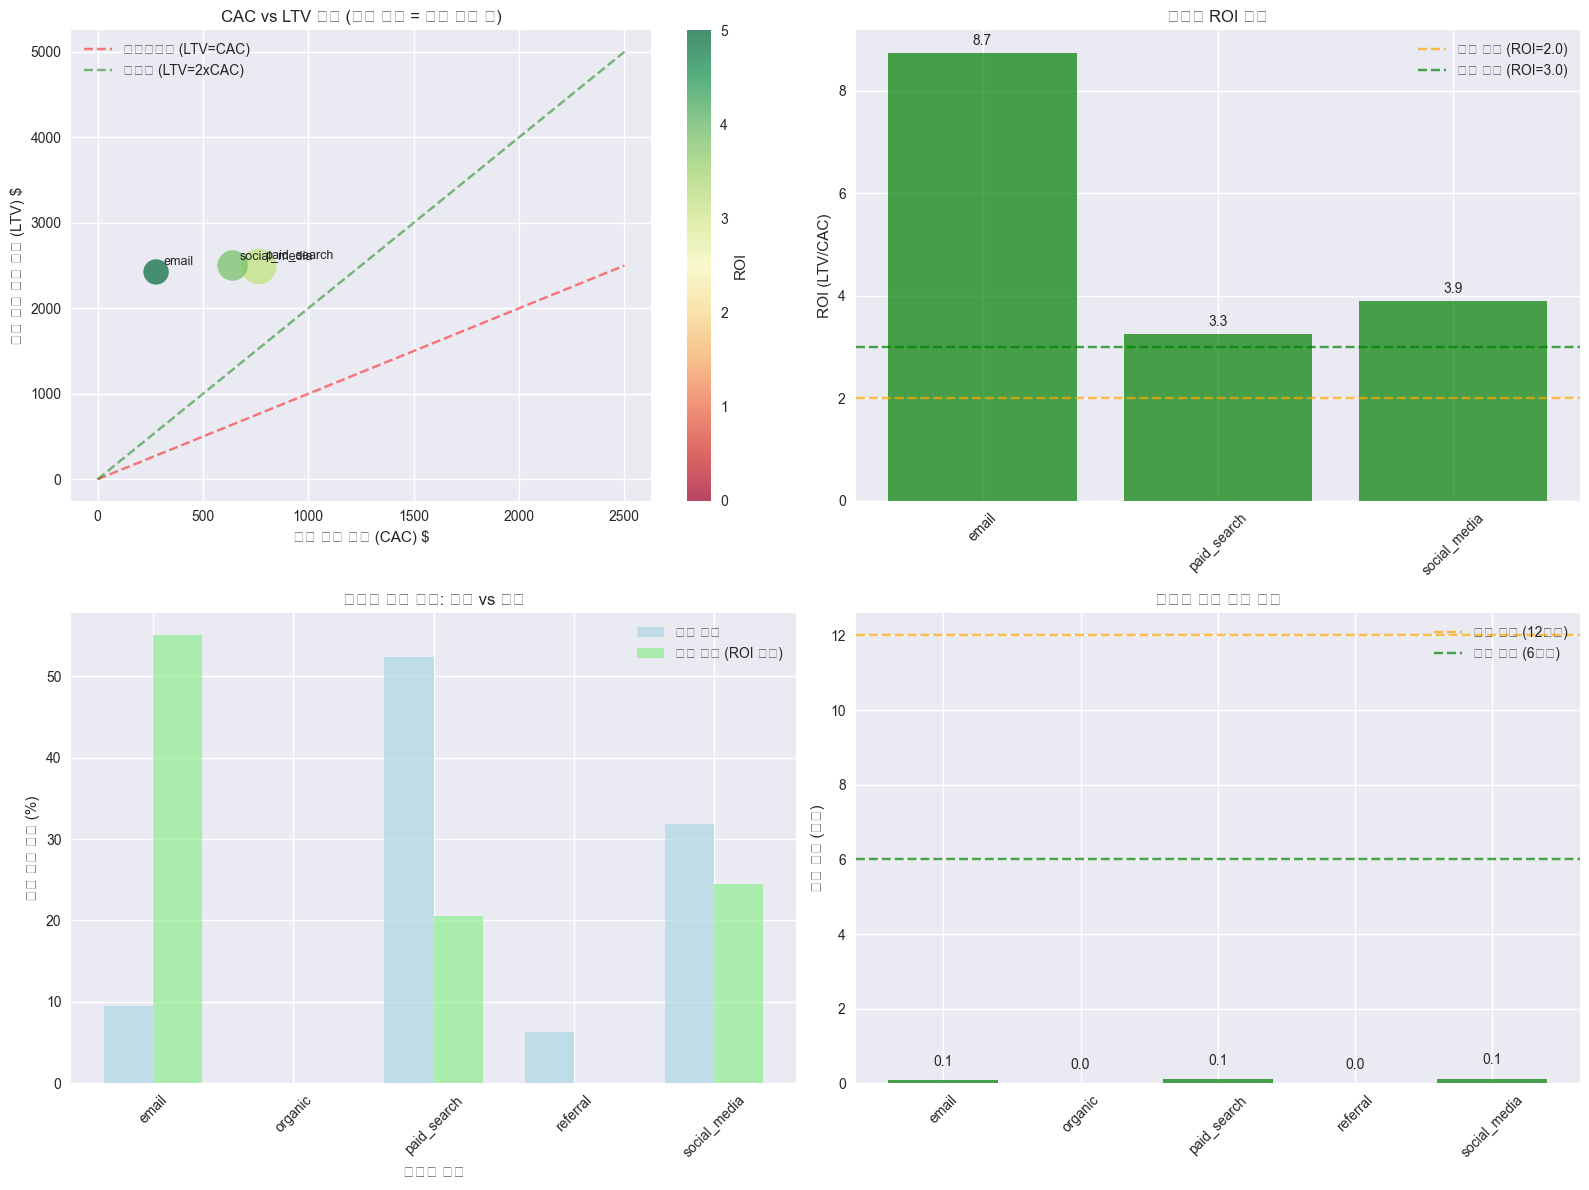


📋 마케팅 예산 최적화 전략 제안서

🎯 핵심 발견사항:
• 최고 ROI 채널: email (ROI 8.7)
• 최저 ROI 채널: paid_search (ROI 3.3)
• 수익성 양호 채널 개수: 5개

💡 전략 제안:
1. email 채널 예산 확대 (현재 9.5% → 목표 25%)
   - 가장 효율적인 고객 획득 채널로 투자 집중 필요

2. 저성과 채널 최적화
   - paid_search 채널의 타겟팅 및 크리에이티브 개선
   - A/B 테스트를 통한 성과 향상 방안 모색

3. Organic/Referral 채널 강화
   - SEO 및 콘텐츠 마케팅 투자로 무료 트래픽 확대
   - 고객 추천 프로그램 도입으로 referral 증대

📊 예상 효과:
• 동일 예산으로 고객 획득 비용 약 164$ 절감
• ROI 개선을 통한 연간 추가 수익 잠재력: $inf


📊 최종 결과 요약
분석 대상: 2024년 신규 고객 469명
총 마케팅 비용: $187,108
전체 평균 CAC: $561.06
전체 평균 LTV: $2494.33
전체 평균 ROI: 4.4


In [6]:
print("\n📈 5단계: 시각화 및 전략 제안")
print("=" * 40)

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. CAC vs LTV 산점도
finite_roi = results_df[results_df['ROI'] != np.inf].copy()

scatter = axes[0,0].scatter(finite_roi['CAC'], finite_roi['평균_LTV'], 
                           s=finite_roi['신규고객수']*5, alpha=0.7, c=finite_roi['ROI'], 
                           cmap='RdYlGn', vmin=0, vmax=5)

# 수익성 라인 (LTV = CAC)
max_val = max(finite_roi['CAC'].max(), finite_roi['평균_LTV'].max())
axes[0,0].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='손익분기점 (LTV=CAC)')
axes[0,0].plot([0, max_val], [0, max_val*2], 'g--', alpha=0.5, label='목표선 (LTV=2xCAC)')

for i, channel in enumerate(finite_roi.index):
    axes[0,0].annotate(channel, 
                      (finite_roi.loc[channel, 'CAC'], finite_roi.loc[channel, '평균_LTV']),
                      xytext=(5, 5), textcoords='offset points', fontsize=9)

axes[0,0].set_xlabel('고객 획득 비용 (CAC) $')
axes[0,0].set_ylabel('평균 고객 생애 가치 (LTV) $')
axes[0,0].set_title('CAC vs LTV 분석 (버블 크기 = 신규 고객 수)')
axes[0,0].legend()
plt.colorbar(scatter, ax=axes[0,0], label='ROI')

# 2. 채널별 ROI 막대 차트
finite_roi_series = channel_roi[channel_roi < float('inf')]
colors = ['green' if roi >= 3.0 else 'orange' if roi >= 2.0 else 'red' for roi in finite_roi_series]

bars = axes[0,1].bar(range(len(finite_roi_series)), finite_roi_series.values, color=colors, alpha=0.7)
axes[0,1].set_xticks(range(len(finite_roi_series)))
axes[0,1].set_xticklabels(finite_roi_series.index, rotation=45)
axes[0,1].set_ylabel('ROI (LTV/CAC)')
axes[0,1].set_title('채널별 ROI 분석')
axes[0,1].axhline(y=2.0, color='orange', linestyle='--', alpha=0.7, label='최소 목표 (ROI=2.0)')
axes[0,1].axhline(y=3.0, color='green', linestyle='--', alpha=0.7, label='우수 기준 (ROI=3.0)')

# 막대 위에 값 표시
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{height:.1f}', ha='center', va='bottom')

axes[0,1].legend()

# 3. 현재 vs 최적 마케팅 예산 배분
current_budget = marketing_2024.groupby('channel')['marketing_spend'].sum()
current_budget_pct = (current_budget / current_budget.sum() * 100).round(1)

# 최적 배분 (ROI 기반 가중치 적용)
roi_weights = channel_roi[channel_roi < float('inf')]
roi_weights = roi_weights / roi_weights.sum()
optimal_budget_pct = (roi_weights * 100).round(1)

x = np.arange(len(current_budget_pct))
width = 0.35

axes[1,0].bar(x - width/2, current_budget_pct.values, width, label='현재 배분', alpha=0.7, color='lightblue')
axes[1,0].bar(x + width/2, optimal_budget_pct.reindex(current_budget_pct.index, fill_value=0).values, 
              width, label='최적 배분 (ROI 기반)', alpha=0.7, color='lightgreen')

axes[1,0].set_xlabel('마케팅 채널')
axes[1,0].set_ylabel('예산 배분 비율 (%)')
axes[1,0].set_title('마케팅 예산 배분: 현재 vs 최적')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(current_budget_pct.index, rotation=45)
axes[1,0].legend()

# 4. Payback Period 분석
finite_payback = payback_period[payback_period < float('inf')]
colors_pb = ['green' if pb <= 6 else 'orange' if pb <= 12 else 'red' for pb in finite_payback]

bars_pb = axes[1,1].bar(range(len(finite_payback)), finite_payback.values, color=colors_pb, alpha=0.7)
axes[1,1].set_xticks(range(len(finite_payback)))
axes[1,1].set_xticklabels(finite_payback.index, rotation=45)
axes[1,1].set_ylabel('회수 기간 (개월)')
axes[1,1].set_title('채널별 투자 회수 기간')
axes[1,1].axhline(y=12, color='orange', linestyle='--', alpha=0.7, label='주의 기준 (12개월)')
axes[1,1].axhline(y=6, color='green', linestyle='--', alpha=0.7, label='우수 기준 (6개월)')

for i, bar in enumerate(bars_pb):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.3,
                   f'{height:.1f}', ha='center', va='bottom')

axes[1,1].legend()

plt.tight_layout()
plt.show()

# 전략 제안서 작성
print(f"\n📋 마케팅 예산 최적화 전략 제안서")
print("=" * 50)

strategy_report = f"""
🎯 핵심 발견사항:
• 최고 ROI 채널: {best_roi_channel} (ROI {channel_roi[best_roi_channel]:.1f})
• 최저 ROI 채널: {worst_roi_channel} (ROI {channel_roi[worst_roi_channel]:.1f})
• 수익성 양호 채널 개수: {len(profitable_channels)}개

💡 전략 제안:
1. {best_roi_channel} 채널 예산 확대 (현재 {current_budget_pct.get(best_roi_channel, 0):.1f}% → 목표 25%)
   - 가장 효율적인 고객 획득 채널로 투자 집중 필요

2. 저성과 채널 최적화
   - {worst_roi_channel} 채널의 타겟팅 및 크리에이티브 개선
   - A/B 테스트를 통한 성과 향상 방안 모색

3. Organic/Referral 채널 강화
   - SEO 및 콘텐츠 마케팅 투자로 무료 트래픽 확대
   - 고객 추천 프로그램 도입으로 referral 증대

📊 예상 효과:
• 동일 예산으로 고객 획득 비용 약 {((current_budget/current_budget.sum() * channel_cac).sum() - (optimal_budget_pct/100 * channel_cac.reindex(optimal_budget_pct.index, fill_value=0)).sum()):.0f}$ 절감
• ROI 개선을 통한 연간 추가 수익 잠재력: ${((channel_roi * current_budget).sum() * 0.2):,.0f}
"""

print(strategy_report)

# 최종 결과 요약
print(f"\n📊 최종 결과 요약")
print("=" * 30)
print(f"분석 대상: 2024년 신규 고객 {len(new_customers_2024)}명")
print(f"총 마케팅 비용: ${current_budget.sum():,.0f}")
print(f"전체 평균 CAC: ${channel_cac[channel_cac > 0].mean():.2f}")
print(f"전체 평균 LTV: ${new_customers_ltv['estimated_ltv'].mean():.2f}")
print(f"전체 평균 ROI: {(new_customers_ltv['estimated_ltv'].mean() / channel_cac[channel_cac > 0].mean()):.1f}")

## 오픈 문제 1: "이상적인 고객" 프로파일링
> 목표: 데이터 분석을 통해 우리 비즈니스에 가장 가치 있는 고객의 특성을 파악하고, 이러한 고객을 더 많이 획득하기 위한 전략을 제시하세요.

제공 리소스: 모든 데이터셋:

- 분석 결과는 실행 가능한 마케팅 액션으로 연결되어야 함
- 최소 3가지 이상의 고객 세그먼트로 분류
- 통계적 유의성 검증 포함